In [35]:
import numpy as np
import matplotlib.pyplot as plt

def make_B(N, N_over_p, T, mode="even"):
    """
    Creates a matrix which undersamples a data vector of length NT.
    
    Args:
        N (int): Length of the of the original signal.
        N_over_p (int): Factor of undersampling which results in 
        copies of undersampled data which is of length p. 
        Must be a whole number.
        T (int): Number of coils s.t. the whole signal is of length NT.
        mode: Method by which the data is undersampled. May be
        one in every N/p samples, the center N/p samples, or a random
        selection of N/p samples.
    
    Returns:
        B_matrix (2D ndarray): A real matrix which is of size TpxTN
        and T length-N signals into T length-p signals. The matrix is
        sparse: pT values are ones and the rest are zeros.
    """
    if mode == "even":
        keep_k = np.arange(N)[::N_over_p]
    if mode == "center":
        approx_p = N//N_over_p
        k1 = (N//N_over_p) - (approx_p//2)
        k2 = (N//N_over_p) + (approx_p//2) + (approx_p%2)
        keep_k = np.arange(N)[k1:k2]
    if mode == "random" or mode == "rand":
        approx_p = N//N_over_p
        keep_k = np.random.choice(np.arange(N), size=approx_p, replace=False)
        keep_k.sort()
    B_p = np.eye(N)[keep_k,:]
    p = B_p.shape[0]
    B_matrix = np.zeros((T*p, T*N))
    for i in range(T):
        B_matrix[i*p:(i+1)*p, i*N:(i+1)*N] = B_p
    return B_matrix

def make_F(N):
    """
    Creates a matrix which performs a Fourier transform on
    a 1D signal.
    
    Args:
        N (int): Length and height of the NxN Fourier transform
        matrix. Should be greater than or equal to the length
        of the signal.
    
    Returns:
        F_matrix (2D ndarray): A complex matrix which, when multiplied
        by a Nx1 signal, results in the Nx1 Fourier transform of that
        signal.
    """
    ind_matrix = np.indices((N,N))
    phase_matrix = 2*np.pi*(ind_matrix[0] * ind_matrix[1])/N
    F_matrix = np.cos(phase_matrix) - 1j * np.sin(phase_matrix)
    return F_matrix

def make_C(C_tuple):
    """
    Creates a matrix of multiple sensitivity maps of the same
    dimensionality stacked on top of each other in the 0th axis.
    
    Args:
        C_tuple: Tuple of T flattened sensitivity maps of the same length N.
        The function returns early if their shapes are not the same.
    
    Returns:
        C_ret: The sensitivity map matrices with dimensionality TNxN.
    """
    C_0_shape = C_tuple[0].shape
    for C in C_tuple:
        if C.shape != C_0_shape:
            print("Mismatch in shape!")
            return
    C_ret = np.diagflat(C_tuple[0])
    for C in C_tuple[1:]:
        C_ret = np.concatenate((C_ret, np.diagflat(C)), axis=0)
    return C_ret





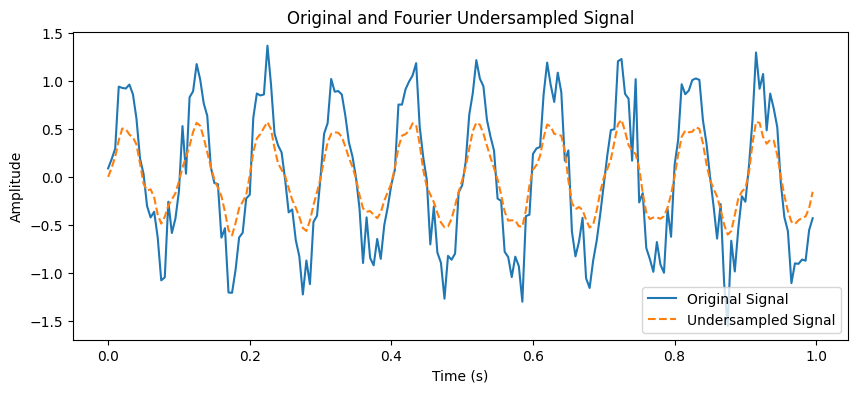

In [38]:
# Create the signal
sample_rate = 200  # Hz
t = np.linspace(0, 1, sample_rate, endpoint=False)
signal = np.sin(2 * np.pi * 10 * t) + 0.2 * np.random.normal(size=t.shape)  # Original signal

# Fourier transform of the signal
signal_fft = np.fft.fft(signal)

# Create a mask for undersampling in the Fourier domain
undersampling_factor = 4
mask = np.zeros_like(signal_fft, dtype=bool)
mask[:len(signal)//undersampling_factor] = True

# Apply the mask and perform inverse Fourier transform
undersampled_fft = signal_fft * mask
undersampled_signal = np.fft.ifft(undersampled_fft).real


plt.figure(figsize=(10, 4))
plt.plot(t, signal, label="Original Signal")
plt.plot(t, undersampled_signal, '--', label="Undersampled Signal")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Original and Fourier Undersampled Signal")
plt.legend()
plt.show()

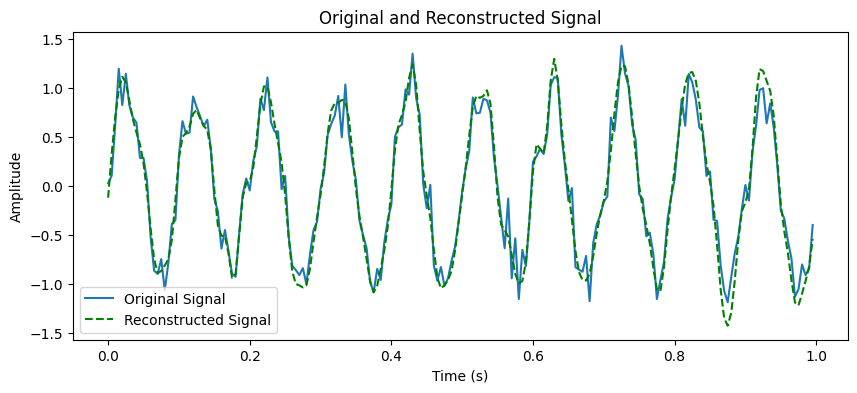

In [37]:
# Analytical reconstruction with coils
num_coils = 3
coil_sensitivities = [1 + 0.1 * i * np.sin(2 * np.pi * i * t) for i in range(1, num_coils + 1)]
coil_data = [undersampled_fft * sensitivity for sensitivity in coil_sensitivities]

# Construct encoding matrix
F_200 = make_F(200)
C_c = make_C([1 + 0.1 * i * np.sin(2 * np.pi * i * t) for i in range(1, num_coils + 1)])
E = np.kron(np.eye(num_coils), F_200) @ C_c

# Create acquired data vector
d = np.concatenate(coil_data)

# Analytical solution
lmbda = 0.01
EH = E.conj().T
rho_hat = np.real(np.linalg.inv(EH @ E + lmbda * np.eye(E.shape[1])) @ EH @ d)

# Scale reconstructed signal to match original amplitude
scaling_factor = np.max(np.abs(signal)) / np.max(np.abs(rho_hat))
rho_hat_scaled = rho_hat[:len(t)] * scaling_factor


plt.figure(figsize=(10, 4))
plt.plot(t, signal, label="Original Signal")
plt.plot(t, rho_hat_scaled, '--', label="Reconstructed Signal", color='g')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Original and Reconstructed Signal")
plt.legend()
plt.show()